# Low-rank approximations for music structure representation and similarity

### Library importing

In [28]:
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp2d
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import directed_hausdorff
from scipy.cluster import hierarchy
from scipy.linalg import eigh
from scipy.ndimage import median_filter
import numpy as np
import cv2
from seaborn import clustermap
from sklearn import metrics
import librosa
import dill
import sys
import glob
import os
import random
import json
import deepdish as dd
import matplotlib.pyplot as plt
%matplotlib inline

### Dill session

In [ ]:
dill.dump_session('sets.db')

In [ ]:
dill.load_session('sets.db')

### Load and compute set of approximation matrices for Da-TACOS

In [3]:
resample_dim = 256 #side size to which to resample Laplacian
kmin = 2 #min components for approximation (>=2)
kmax = 10 #max component for approximation

with open('./da-tacos_metadata/da-tacos_benchmark_subset_metadata.json') as f:
    benchmark_metadata = json.load(f)
count = 0
W_count=0
P_count = 0
all_sets = []
all_shapeDNAs = []
all_WP = []
y = []
for W in benchmark_metadata.keys():
    if len(benchmark_metadata[W].keys()) > 4: #if it contains at least 5 covers
        P_count = 0
        for P in benchmark_metadata[W].keys():
            P_count += 1
            
            #Computations
            try:
                SSM = dd.io.load("./da-tacosSSMs/StructureLaplacian_datacos_crema_" + P + ".h5")['WFused']
            except:
                print("Couldn't load " + P + ".")
                continue

            N = dd.io.load("./da-tacosSSMs/StructureLaplacian_datacos_crema_" + P + ".h5")['N']

            #Construct square matrix from flattened upper triangle
            A = np.zeros((N,N))
            iN = np.triu_indices(N) #return indices for upper-triangle of (N,N) matrix
            for i in range(len(SSM)):
                A[iN[0][i]][iN[1][i]] = SSM[i]
            B = np.transpose(A)
            square_SSM = A+B

            #Resample
            Xindex = np.linspace(0, 1, num=N)
            f = interp2d(Xindex, Xindex, square_SSM.flatten(), kind='linear')
            Xindex_ds = np.linspace(0, 1, num=resample_dim)
            SSM_ds = np.reshape(f(Xindex_ds, Xindex_ds), (resample_dim,resample_dim))

            #Compute the Laplacian
            L = laplacian(SSM_ds, normed=True)

            #Laplacian eigenvalues and eigenvectors
            evals, evecs = eigh(L)

            #Shape DNA
            shapeDNA = evals[:30]
            all_shapeDNAs.append(shapeDNA)

            #Hierarchical structure
            evecs = median_filter(evecs, size=(9, 1))
            Cnorm = np.cumsum(evecs**2, axis=1)**0.5
            dist_set = []
            for k in range(kmin, kmax):
                X = evecs[:, :k] / Cnorm[:, k-1:k]
                distance = squareform(pdist(X, metric='euclidean'))
                dist_set.append(distance)

            all_sets.append(dist_set)
            y.append(W)

            #append W and P
            all_WP.append([W, P])

            #plt.matshow()
            #plt.colorbar()
            #plt.show()

            if (P_count >=5):
                break
                
        W_count +=1
        sys.stdout.write("\rLoading %i/100 works." % W_count)
        sys.stdout.flush()
        if (W_count >= 100):
            break
            
all_sets = np.asarray(all_sets)
all_shapeDNAs = np.asarray(all_shapeDNAs)

print("\nLoaded Da-TACOS SMMs.")
print("Data shape:", all_sets.shape)

Loading 100/100 works.
Loaded Da-TACOS SMMs.
Data shape: (500, 8, 256, 256)


In [4]:
dill.dump_session('100Wx5P_2-8set_30shapeDNA.db')

In [2]:
dill.load_session('100Wx5P_2-8set_30shapeDNA.db')

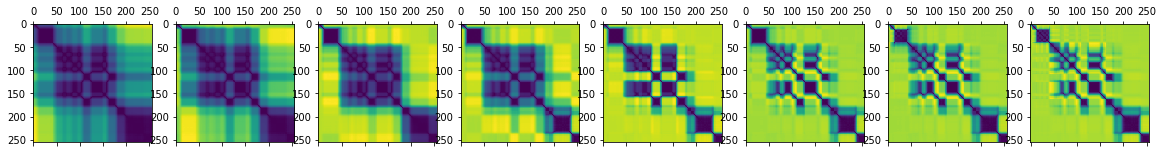

In [3]:
fig, axs = plt.subplots(1, kmax-kmin, figsize=(20, 20))
for i in range(kmax-kmin):
    axs[i].matshow(all_sets[0][i])
plt.show()

### Flatten upper triangles of each approximation matrix

In [4]:
all_flatsets = []
for i in range(all_sets.shape[0]):
    all_flatsets.append([])
    for j in range(all_sets.shape[1]):
        all_flatsets[i].append((all_sets[i][j])[np.triu_indices(all_sets[i][j].shape[0])])
all_flatsets = np.asarray(all_flatsets)
print(all_flatsets.shape)

(500, 8, 32896)


### Merge flattened approximation triangles

In [5]:
all_merged = []
for i in range(all_flatsets.shape[0]):
    all_merged.append(np.empty((0)))
    for k in range(kmax-kmin):
        all_merged[i] = np.concatenate((all_merged[i], all_flatsets[i][k]))
all_merged = np.asarray(all_merged)
print(all_merged.shape)

(500, 263168)


### Cover/Non-cover pairs

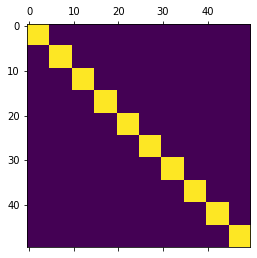

In [6]:
#True if cover, False if non-cover
covers = np.zeros((len(all_WP), len(all_WP)), dtype=np.bool_)
for i in range(len(all_WP)):
    for j in range(len(all_WP)):
        if (all_WP[i][0] == all_WP[j][0]):
            covers[i][j] = True
        else:
            covers[i][j] = False
plt.matshow(covers[:50, :50])
plt.show()

### L1 norm (average from Y1i-Y2i)

Loading 500/500 pieces.

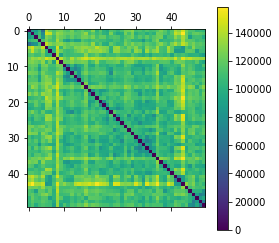

In [10]:
L1_distances = np.zeros((all_merged.shape[0], all_merged.shape[0]))
for i in range(all_flatsets.shape[0]):
    for j in range(all_flatsets.shape[0]):
        L1_distances[i][j] = np.linalg.norm(all_merged[i]-all_merged[j], ord=1)
    sys.stdout.write("\rLoading %i/500 pieces." % (i+1))
    sys.stdout.flush()
plt.matshow(L1_distances[:50, :50])
plt.colorbar()
plt.show()

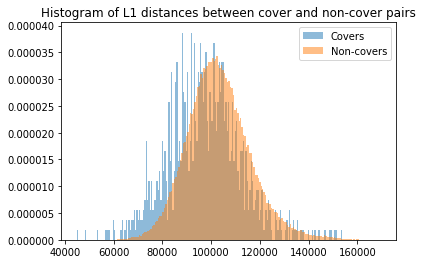

In [14]:
L1_distances_covers = []
L1_distances_noncovers = []
for i in range(all_flatsets.shape[0]):
    for j in range(all_flatsets.shape[0]):
        if covers[i][j]:
            if (L1_distances[i][j] != 0):
                L1_distances_covers.append(L1_distances[i][j])
        else:
            L1_distances_noncovers.append(L1_distances[i][j])
            
plt.figure()
plt.hist(L1_distances_covers, bins=200, alpha=0.5, label='Covers', density=1)
plt.hist(L1_distances_noncovers, bins=200, alpha=0.5, label='Non-covers', density=1)
plt.title("Histogram of L1 distances between cover and non-cover pairs")
plt.legend(loc='upper right')
plt.show()

### L2 norm (average from Y1i-Y2i)

Loading 500/500 pieces.

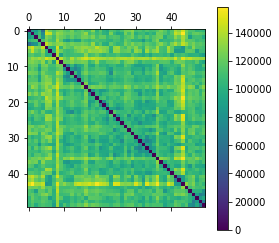

In [12]:
L2_distances = np.zeros((all_merged.shape[0], all_merged.shape[0]))
for i in range(all_flatsets.shape[0]):
    for j in range(all_flatsets.shape[0]):
        L2_distances[i][j] = np.linalg.norm(all_merged[i]-all_merged[j])
    sys.stdout.write("\rLoading %i/500 pieces." % (i+1))
    sys.stdout.flush()
plt.matshow(L1_distances[:50, :50])
plt.colorbar()
plt.show()

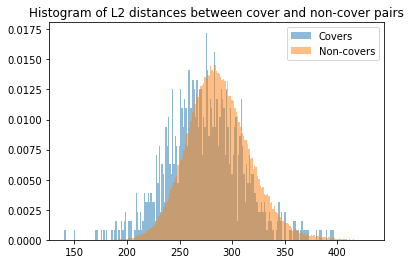

In [15]:
L2_distances_covers = []
L2_distances_noncovers = []
for i in range(all_flatsets.shape[0]):
    for j in range(all_flatsets.shape[0]):
        if covers[i][j]:
            if (L2_distances[i][j] != 0):
                L2_distances_covers.append(L2_distances[i][j])
        else:
            L2_distances_noncovers.append(L2_distances[i][j])
            
plt.figure()
plt.hist(L2_distances_covers, bins=200, alpha=0.5, label='Covers', density=1)
plt.hist(L2_distances_noncovers, bins=200, alpha=0.5, label='Non-covers', density=1)
plt.title("Histogram of L2 distances between cover and non-cover pairs")
plt.legend(loc='upper right')
plt.show()

### Sub-sequence Dynamic Time Warping cost

In [ ]:
dtw_cost = np.zeros((all_merged.shape[0], all_merged.shape[0]))
for i in range(all_flatsets.shape[0]):
    for j in range(all_flatsets.shape[0]):
        costs = []
        for k in range(kmax-kmin):
            costs.append(librosa.sequence.dtw(all_flatsets[i][k], all_flatsets[j][k], subseq=True, metric='euclidean')[0][resample_dim, resample_dim])
        L2_distances[i][j] = sum(costs)/len(costs)
    sys.stdout.write("\rLoading %i/500 pieces." % (i+1))
    sys.stdout.flush()
plt.matshow(dtw_cost[:50, :50])
plt.colorbar()
plt.show()

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
dtw_cost_covers = []
dtw_cost_noncovers = []
for i in range(all_flatsets.shape[0]):
    for j in range(all_flatsets.shape[0]):
        if covers[i][j]:
            if (dtw_cost[i][j] != 0):
                dtw_cost_covers.append(dtw_cost[i][j])
        else:
            dtw_cost_noncovers.append(dtw_cost[i][j])
            
plt.figure()
plt.hist(dtw_cost_covers, bins=200, alpha=0.5, label='Covers', density=1)
plt.hist(dtw_cost_noncovers, bins=200, alpha=0.5, label='Non-covers', density=1)
plt.title("Histogram of subsequence DTW cost between cover and non-cover pairs")
plt.legend(loc='upper right')
plt.show()

### Directed Hausdorff distance

Loading 500/500 pieces.

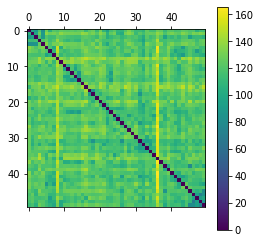

In [8]:
hausdorff_distances = np.zeros((all_flatsets.shape[0], all_flatsets.shape[0]))
for i in range(all_flatsets.shape[0]):
    for j in range(all_flatsets.shape[0]):
        hausdorff_distances[i][j] = (directed_hausdorff(all_flatsets[i], all_flatsets[j]))[0]
    sys.stdout.write("\rLoading %i/500 pieces." % (i+1))
    sys.stdout.flush()
plt.matshow(hausdorff_distances[:50, :50])
plt.colorbar()
plt.show()

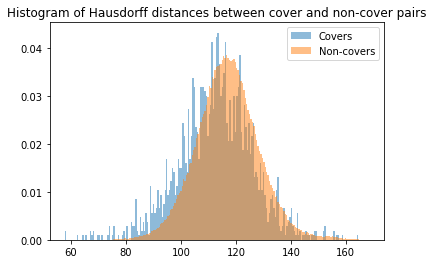

In [16]:
hausdorff_distances_covers = []
hausdorff_distances_noncovers = []
for i in range(all_flatsets.shape[0]):
    for j in range(all_flatsets.shape[0]):
        if covers[i][j]:
            if (hausdorff_distances[i][j] != 0):
                hausdorff_distances_covers.append(hausdorff_distances[i][j])
        else:
            hausdorff_distances_noncovers.append(hausdorff_distances[i][j])
            
plt.figure()
plt.hist(hausdorff_distances_covers, bins=200, alpha=0.5, label='Covers', density=1)
plt.hist(hausdorff_distances_noncovers, bins=200, alpha=0.5, label='Non-covers', density=1)
plt.title("Histogram of Hausdorff distances between cover and non-cover pairs")
plt.legend(loc='upper right')
plt.show()

### Minimum distance from Y1i to Y2j for all (i,j)

Loading 500/500 pieces.

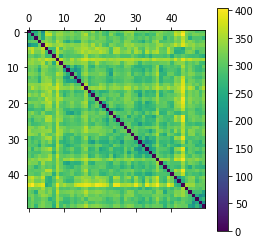

In [19]:
min_distances = np.zeros((all_flatsets.shape[0], all_flatsets.shape[0]))
for i in range(all_flatsets.shape[0]):
    for j in range(all_flatsets.shape[0]):
        dists = []
        for n in range(kmax-kmin):
            for m in range(kmax-kmin):
                dists.append(np.linalg.norm(all_merged[i]-all_merged[j]))
        min_distances[i][j] = min(dists)
    sys.stdout.write("\rLoading %i/500 pieces." % (i+1))
    sys.stdout.flush()
plt.matshow(min_distances[:50, :50])
plt.colorbar()
plt.show()

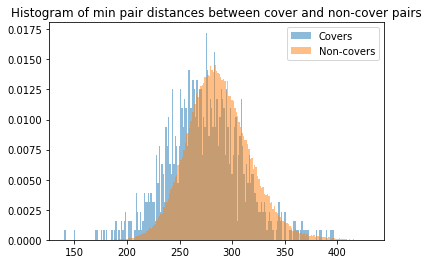

In [20]:
min_distances_covers = []
min_distances_noncovers = []
for i in range(all_flatsets.shape[0]):
    for j in range(all_flatsets.shape[0]):
        if covers[i][j]:
            if (min_distances[i][j] != 0):
                min_distances_covers.append(min_distances[i][j])
        else:
            min_distances_noncovers.append(min_distances[i][j])
            
plt.figure()
plt.hist(min_distances_covers, bins=200, alpha=0.5, label='Covers', density=1)
plt.hist(min_distances_noncovers, bins=200, alpha=0.5, label='Non-covers', density=1)
plt.title("Histogram of min pair distances between cover and non-cover pairs")
plt.legend(loc='upper right')
plt.show()

### ROC curves

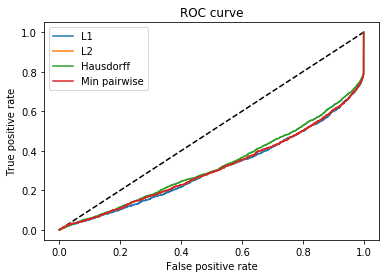

In [29]:
fpr_L1_distances, tpr_L1_distances, thresholds_L1_distances = metrics.roc_curve(covers.flatten(), L1_distances.flatten())
fpr_L2_distances, tpr_L2_distances, thresholds_L2_distances = metrics.roc_curve(covers.flatten(), L2_distances.flatten())
fpr_hausdorff_distances, tpr_hausdorff_distances, thresholds_hausdorff_distances = metrics.roc_curve(covers.flatten(), hausdorff_distances.flatten())
fpr_min_distances, tpr_min_distances, thresholds_min_distances = metrics.roc_curve(covers.flatten(), min_distances.flatten())

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_L1_distances, tpr_L1_distances, label='L1')
plt.plot(fpr_L2_distances, tpr_L2_distances, label='L2')
plt.plot(fpr_hausdorff_distances, tpr_hausdorff_distances, label='Hausdorff')
plt.plot(fpr_min_distances, tpr_min_distances, label='Min pairwise')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Shape DNA

In [30]:
shapeDNA_distances = np.zeros((all_shapeDNAs.shape[0], all_shapeDNAs.shape[0]))
for i in range(all_shapeDNAs.shape[0]):
    for j in range(all_shapeDNAs.shape[0]):
        shapeDNA_distances[i][j] = np.linalg.norm(all_shapeDNAs[i]-all_shapeDNAs[j])

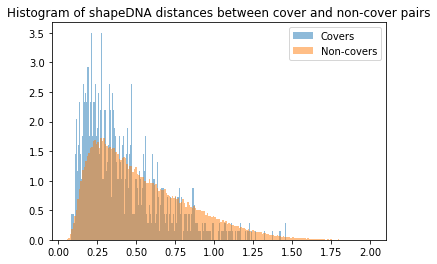

In [31]:
#create distribution graphs
shapeDNA_covers = []
shapeDNA_noncovers = []
for i in range(all_shapeDNAs.shape[0]):
    for j in range(all_shapeDNAs.shape[0]):
        if (covers[i][j] == 1):
            if (shapeDNA_distances[i][j] != 0): 
                shapeDNA_covers.append(shapeDNA_distances[i][j])
        else:
            shapeDNA_noncovers.append(shapeDNA_distances[i][j])

plt.figure()
plt.hist(shapeDNA_covers, bins=200, alpha=0.5, label='Covers', density=1)
plt.hist(shapeDNA_noncovers, bins=200, alpha=0.5, label='Non-covers', density=1)
plt.title("Histogram of shapeDNA distances between cover and non-cover pairs")
plt.legend(loc='upper right')
plt.show()

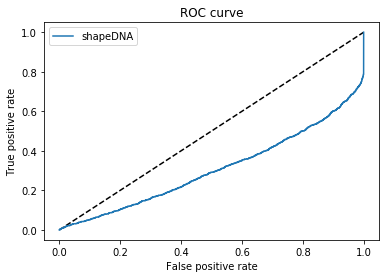

In [33]:
fpr_shapeDNA_distances, tpr_shapeDNA_distances, thresholds_shapeDNA_distances = metrics.roc_curve(covers.flatten(), shapeDNA_distances.flatten())
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_L1_distances, tpr_L1_distances, label='shapeDNA')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Shape DNA and low-rank approximations with AUC

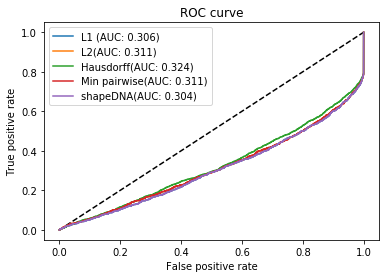

In [39]:
# fpr_L1_distances, tpr_L1_distances, thresholds_L1_distances = metrics.roc_curve(covers.flatten(), L1_distances.flatten())
# fpr_L2_distances, tpr_L2_distances, thresholds_L2_distances = metrics.roc_curve(covers.flatten(), L2_distances.flatten())
# fpr_hausdorff_distances, tpr_hausdorff_distances, thresholds_hausdorff_distances = metrics.roc_curve(covers.flatten(), hausdorff_distances.flatten())
# fpr_min_distances, tpr_min_distances, thresholds_min_distances = metrics.roc_curve(covers.flatten(), min_distances.flatten())
# fpr_shapeDNA_distances, tpr_shapeDNA_distances, thresholds_shapeDNA_distances = metrics.roc_curve(covers.flatten(), shapeDNA_distances.flatten())

roc_auc_L1_distances = metrics.roc_auc_score(covers.flatten(), L1_distances.flatten())
roc_auc_L2_distances = metrics.roc_auc_score(covers.flatten(), L2_distances.flatten())
roc_auc_hausdorff_distances = metrics.roc_auc_score(covers.flatten(), hausdorff_distances.flatten())
roc_auc_min_distances = metrics.roc_auc_score(covers.flatten(), min_distances.flatten())
roc_auc_shapeDNA_distances = metrics.roc_auc_score(covers.flatten(), shapeDNA_distances.flatten())

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_L1_distances, tpr_L1_distances, label='L1 ' + '(AUC: ' + str(round(roc_auc_L1_distances,3)) + ')')
plt.plot(fpr_L2_distances, tpr_L2_distances, label='L2' + '(AUC: ' + str(round(roc_auc_L2_distances,3)) + ')')
plt.plot(fpr_hausdorff_distances, tpr_hausdorff_distances, label='Hausdorff' + '(AUC: ' + str(round(roc_auc_hausdorff_distances,3)) + ')')
plt.plot(fpr_min_distances, tpr_min_distances, label='Min pairwise' + '(AUC: ' + str(round(roc_auc_min_distances,3)) + ')')
plt.plot(fpr_L1_distances, tpr_L1_distances, label='shapeDNA' + '(AUC: ' + str(round(roc_auc_shapeDNA_distances,3)) + ')')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()